# Макар Кулишенко, ИАД-8
# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [180]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


Заметим, что признаки salary и salary_in_usd напрямую связаны между собой, поэтому при обучении модели она будет опираться именно на это значение. Чтобы такого не происходило, удалим столбец salary.

In [181]:
from sklearn.model_selection import train_test_split

df.drop(['salary'], axis=1, inplace=True)
y = pd.DataFrame({'salary' : df['salary_in_usd'],
     'category' : df['salary_in_usd']})

X = df.drop(['salary_in_usd'], axis=1,)
X.head()

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,EUR,ES,100,ES,L
1,2023,MI,CT,ML Engineer,USD,US,100,US,S
2,2023,MI,CT,ML Engineer,USD,US,100,US,S
3,2023,SE,FT,Data Scientist,USD,CA,100,CA,M
4,2023,SE,FT,Data Scientist,USD,CA,100,CA,M


Я добавил второй признак в у для того, чтобы более равномерно разбить выборку на обучающую, валидационную и тестовую в зависимости от диапазона заработной платы.

Введем этот диапазон.

In [182]:
min_sal = min(y['salary'])
max_sal = max(y['salary'])
print(min_sal, max_sal)

5132 450000


Можно посчитать оптимальное число интервалов по формуле Стерджесса.

In [183]:
import math
inter = math.ceil(3.32 * math.log10(len(df))) + 1
diff = round((max_sal - min_sal) / 6)
print(inter, diff)

13 74145


Но... при таком раскладе у нас получилось, что в последней категории у нас 1 значение, что мешает при дальнейшнем разбиении. Поэтому возьмем число категорий, равное 6

In [184]:
def categorize(value):
  for i in range(6):
    if min_sal + diff * i <= value < min_sal + diff * (i + 1):
      return i


y['category'] = y['category'].apply(categorize)
y.head()

,salary,category
0,85847,1
1,30000,0
2,25500,0
3,175000,2
4,120000,1


In [185]:
X_train, X_test_, y_train, y_test_ = train_test_split(X, y, test_size=0.2, stratify=y['category'], random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_, y_test_, test_size=0.5, stratify=y_test_['category'])

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


Закодируем категориальные переменные через OHE и отскалируем числовые с помощью StandardScaler для улучшения качества модели.

In [216]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()
ohe = ColumnTransformer(transformers=[("ohe", encoder, ['experience_level', 'employment_type', 'job_title',
                                                        'salary_currency', 'employee_residence', 'company_location', 'company_size']),
                                      ("scaler", scaler, ['work_year', 'remote_ratio'])],
    remainder="passthrough")

ohe.set_output(transform="pandas")
ohe.fit(X_train)
X_train_t = ohe.transform(X_train)
X_test_t = ohe.transform(X_test)
X_val_t = ohe.transform(X_val)
X_test_t.head()

,ohe__experience_level_EN,ohe__experience_level_EX,ohe__experience_level_MI,ohe__experience_level_SE,ohe__employment_type_CT,ohe__employment_type_FL,ohe__employment_type_FT,ohe__employment_type_PT,ohe__job_title_3D Computer Vision Researcher,ohe__job_title_AI Developer,...,ohe__company_location_SK,ohe__company_location_TH,ohe__company_location_TR,ohe__company_location_UA,ohe__company_location_US,ohe__company_size_L,ohe__company_size_M,ohe__company_size_S,scaler__work_year,scaler__remote_ratio
2821,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.539642,1.104199
282,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.914246,1.104199
2626,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.539642,1.104199
2697,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.539642,1.104199
1952,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.539642,-0.953502


In [ ]:
linreg = LinearRegression()
linreg.fit(X_train_t, y_train['salary'])
res = linreg.predict(X_test_t)

print('MAPE: ', mean_absolute_percentage_error(y_test['salary'], res))
print('RMSE: ', mean_squared_error(y_test['salary'], res)**0.5)

MAPE:  3323133180.8435054
RMSE:  646089630025845.6


Заметим, что качество модели очень плохое. Возможно, имеет место быть переобучение. Посмотрим на качество на тренировочной выборке.

In [ ]:
res_tr = linreg.predict(X_train_t)
print('MAPE: ', mean_absolute_percentage_error(y_train['salary'], res_tr))
print('RMSE: ', mean_squared_error(y_train['salary'], res_tr)**0.5)

MAPE:  0.3014293349088168
RMSE:  44776.887693158016


Ошибки значительно уменьшились, что может говорить о том, что модель подогналась под тренировочные данные.

## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

В качестве метрики качества возьмем MSE - хорошо подходит для регрессии

In [ ]:
from itertools import product
import numpy as np
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
import sys

depth = np.arange(1, 20, 1)
n_estimators = np.arange(100, 2000, 200)
learning_rate = np.arange(0.01, 0.5, 0.05)
gamma = np.arange(0, 1, 0.1)

# Насчнем подбор с наиболее существенных параметров - learning rate и number of estimators
minn = float('inf')
s = ''
for pair in product(n_estimators, learning_rate):
  xgb = XGBRegressor(n_estimators=pair[0], learning_rate=pair[1])
  xgb.fit(X_train_t, y_train['salary'])
  pred = xgb.predict(X_val_t)
  mse = mean_squared_error(y_val['salary'], pred)
  if mse < minn:
    minn = mse
    s = f'n_estimators = {pair[0]}, learning_rate = {pair[1]}, mse = {mse}'
print(s)

n_estimators = 100, learning_rate = 0.11, mse = 2321355268.0903673


In [ ]:
# Подберем глубину и гамму на модели с n_estimators = 100, learning_rate = 0.11
minn = float('inf')
s = ''
for pair in product(depth, gamma):
  xgb = XGBRegressor(max_depth=pair[0], gamma=pair[1], n_estimators=100, learning_rate=0.11)
  xgb.fit(X_train_t, y_train['salary'])
  pred = xgb.predict(X_val_t)
  mse = mean_squared_error(y_val['salary'], pred)
  if mse < minn:
    minn = mse
    s = f'max_depth = {pair[0]}, gamma = {pair[1]}, mse = {mse}'
print(s)

max_depth = 4, gamma = 0.0, mse = 2317294966.9027257


Обучим бустинг с подобранными параметрами.

In [ ]:
from xgboost.sklearn import XGBRegressor
import time

params = {
    'max_depth' : 4,
    'learning_rate' : 0.11 ,
    'n_estimators' : 100 ,
    'gamma' : 0,
}

xgb = XGBRegressor(max_depth=params['max_depth'], learning_rate=params['learning_rate'], n_estimators=params['n_estimators'], gamma=params['gamma'])
start = time.time()
xgb.fit(X_train_t, y_train['salary'])
end = time.time()
print(f"Total learning time: {end - start}")

Total learning time: 0.31127119064331055


In [ ]:
start = time.time()
pred = xgb.predict(X_test_t)
end = time.time()
print(f"Total prediction time: {end - start}")
print('MAPE: ', mean_absolute_percentage_error(pred, y_test['salary']))
print('RMSE: ', mean_squared_error(pred, y_test['salary']) ** 0.5)

Total prediction time: 0.05848407745361328
MAPE:  0.28041816945118947
RMSE:  48121.67084687071


Отлично! Мы получили очень хорошие значения метрик, что говорит о том, что XGB-бустинг сработал хорошо.

Время обучения бустинга на датасете из ~3000 элементов - 0.3 секунды. Время прогнозирования для 375 элементов - 0.05 секунды.

## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.4 MB/s eta 0:00:00


In [192]:
from catboost import CatBoostRegressor
iterations = np.arange(100, 1000, 100)
learning_rate = np.arange(0.01, 0.5, 0.05)
depth = np.arange(3, 12, 1)

# Насчнем подбор с наиболее существенных параметров - learning rate, iterations и depth
minn = float('inf')
s = ''
for pair in product(depth, learning_rate, iterations):
  cb = CatBoostRegressor(depth=pair[0], learning_rate=pair[1], iterations=pair[2])
  cb.fit(X_train_t, y_train['salary'], verbose=False)
  pred = cb.predict(X_val_t)
  mse = mean_squared_error(y_val['salary'], pred)
  if mse < minn:
    minn = mse
    s = f'depth = {pair[0]}, learning_rate = {pair[1]}, iterations = {pair[2]}, mse = {mse}'
print(s)

depth = 3, learning_rate = 0.01, iterations = 100, mse = 4246604566.033577


Получилось довольно большое значение MSE. Попробуем перебрать learning rate и depth при iterations = 100.

In [238]:
learning_rate = np.arange(0.01, 0.3, 0.009)
depth = np.arange(4, 10, 1)
minn = float('inf')
s = ''
for pair in product(depth, learning_rate):
  cb = CatBoostRegressor(depth=pair[0], learning_rate=pair[1], iterations=100)
  cb.fit(X_train_t, y_train['salary'], verbose=False)
  pred = cb.predict(X_val_t)
  mse = mean_squared_error(y_val['salary'], pred)
  if mse < minn:
    minn = mse
    s = f'depth = {pair[0]}, learning rate = {pair[1]}, mse = {mse}'
print(s)

depth = 7, learning rate = 0.217, mse = 2394399694.1552672


Подберем значение коэффициента L2-регуляризации.

In [249]:
l2 = np.arange(0.5, 10, 0.5)

for i in l2:
  cb = CatBoostRegressor(depth=7, learning_rate=0.217, iterations=100, l2_leaf_reg=i)
  cb.fit(X_train_t, y_train['salary'], verbose=False)
  pred = cb.predict(X_val_t)
  mse = mean_squared_error(y_val['salary'], pred)
  if mse < minn:
    minn = mse
    s = f'l2 leaf reg = {i}, mse = {mse}'
print(s)

l2 leaf reg = 1.5, mse = 2376309455.328728


In [254]:
params = {
    'depth' : 7,
    'learning_rate' : 0.217 ,
    'iterations' : 100 ,
    'l2' : 1.5,
}

cb = CatBoostRegressor(depth=params['depth'], learning_rate=params['learning_rate'], iterations=params['iterations'], l2_leaf_reg=1.5)
start = time.time()
cb.fit(X_train_t, y_train['salary'], verbose=False)
end = time.time()
print(f"Total learning time: {end - start}")

Total learning time: 0.25363731384277344


In [260]:
start = time.time()
pred = cb.predict(X_test_t)
end = time.time()
print(f"Total prediction time: {end - start}")
print('MAPE: ', mean_absolute_percentage_error(pred, y_test['salary']))
print('RMSE: ', mean_squared_error(pred, y_test['salary']) ** 0.5)

Total prediction time: 0.017439603805541992
MAPE:  0.27531486312268566
RMSE:  47063.943743641714


Мы видим, что значение ошибок осталось примерно на таком же уровне (чуть меньше, чем у XGB), время обучения примерно такое же (что может быть особо выгодно на больших данных), но время предсказания для 375 объектов уменьшилось в 5 раз.

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [258]:
X_train

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size
3342,2022,SE,FT,Data Architect,USD,US,100,US,M
2096,2022,MI,FT,Machine Learning Scientist,USD,US,0,US,M
98,2023,SE,FT,Data Engineer,USD,US,100,US,M
1933,2022,EX,FT,Data Engineer,USD,US,100,US,M
2136,2022,SE,FT,Machine Learning Engineer,USD,US,0,US,M
...,...,...,...,...,...,...,...,...,...
2752,2022,SE,FT,Data Scientist,USD,US,100,US,M
1152,2023,SE,FT,Data Engineer,USD,US,0,US,M
1385,2023,SE,FT,Data Scientist,USD,US,0,US,M
2005,2022,SE,FT,Machine Learning Engineer,USD,US,100,US,M


In [259]:
from catboost import Pool

categorical_features = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']

train_pool = Pool(data=X_train, label=y_train['salary'], cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

cat = CatBoostRegressor(verbose=False)
start = time.time()
cat.fit(train_pool)
end = time.time()
print(f"Total learning time: {end - start}")

Total learning time: 6.52798867225647


In [262]:
start = time.time()
pred = cat.predict(X_test)
end = time.time()
print(f"Total prediction time: {end - start}")
print('MAPE: ', mean_absolute_percentage_error(pred, y_test['salary']))
print('RMSE: ', mean_squared_error(pred, y_test['salary']) ** 0.5)

Total prediction time: 0.015404939651489258
MAPE:  0.271962082139108
RMSE:  46530.87794172594


**Ответ:** Время обучения существенно выросло, но при этом ошибка RMSE уменьшилась (пусть и не сильно), что можети говорить о том, что внутри CatBoost уже заложен оптимальный encoder, который лучшим образом кодирует категориальные признаки.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


Начнем с подбора количества деревьев при фиксированном learning rate.

In [268]:
from lightgbm import LGBMRegressor

n_estimators = np.arange(100, 1000, 100)
learning_rate = np.arange(0.01, 0.5, 0.05)
depth = np.arange(3, 12, 1)

minn = float('inf')
s = ''
for i in n_estimators:
  lgbm = LGBMRegressor(n_estimators=i, learning_rate=0.1, verbose=0)
  lgbm.fit(X_train_t, y_train['salary'])
  pred = lgbm.predict(X_val_t)
  mse = mean_squared_error(y_val['salary'], pred)
  if mse < minn:
    minn = mse
    s = f'n_estimators = {i}, mse = {mse}'
print(s)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
n_estimators = 200, mse = 2581138153.695924


Перейдем к learning rate

In [269]:
minn = float('inf')
s = ''
for i in learning_rate:
  lgbm = LGBMRegressor(n_estimators=200, learning_rate=i, verbose=0)
  lgbm.fit(X_train_t, y_train['salary'])
  pred = lgbm.predict(X_val_t)
  mse = mean_squared_error(y_val['salary'], pred)
  if mse < minn:
    minn = mse
    s = f'learning rate = {i}, mse = {mse}'
print(s)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
learning rate = 0.11, mse = 2606105882.8460364


И подберем еще максимальное число листьев

In [279]:
leaves = np.arange(10, 1000, 50)
minn = float('inf')
s = ''
for i in leaves:
  lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.11, num_leaves=i, verbose=0)
  lgbm.fit(X_train_t, y_train['salary'])
  pred = lgbm.predict(X_val_t)
  mse = mean_squared_error(y_val['salary'], pred)
  if mse < minn:
    minn = mse
    s = f'leaves = {i}, mse = {mse}'
print(s)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

А максимальная глубина:

In [280]:
leaves = np.arange(10, 1000, 50)
minn = float('inf')
s = ''
for i in depth:
  lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.11, max_depth=i, num_leaves=10, verbose=0)
  lgbm.fit(X_train_t, y_train['salary'])
  pred = lgbm.predict(X_val_t)
  mse = mean_squared_error(y_val['salary'], pred)
  if mse < minn:
    minn = mse
    s = f'depth = {i}, mse = {mse}'
print(s)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [281]:
params = {
    'max_depth' : 3,
    'learning_rate' : 0.11,
    'n_estimators' : 200,
    'num_leaves' : 10,
}

lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.11, max_depth=3, num_leaves=10, verbose=0)
start = time.time()
lgbm.fit(X_train_t, y_train['salary'])
end = time.time()
print(f"Total learning time: {end - start}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [282]:
start = time.time()
pred = lgbm.predict(X_test_t)
end = time.time()
print(f"Total prediction time: {end - start}")
print('MAPE: ', mean_absolute_percentage_error(pred, y_test['salary']))
print('RMSE: ', mean_squared_error(pred, y_test['salary']) ** 0.5)

Total prediction time: 0.009270668029785156
MAPE:  0.2753328273775422
RMSE:  46307.814178844164


Заметим, что значение ошибки приблизительно такое же, как и у CatBoost, при этом время обучение уменьшилось в 2 раза (оправдывает название).

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

В целом, все виды бустинга, рассмотренные выше, показали приблизительно одинаково хорошие результаты.

###Характеристики

Самая высокая скорость обучения - у LightGBM (она в 2 раза выше, чем у CatBoost и XGBoost и равна **0.14с** для использованного датасета). Это логично, поскольку основным преимуществом данного бустинга является быстрое обучение на больших данных. Среди (возможных) недостатков - необходимость кодирования категориальныз признаков перед использованием.

Самое низкое значение MAPE - у CatBoost'а при использовании Pool **(0,2723)**. Данный бустинг был создан для работы с категориальными признаками, поэтому имеет хорошие встроенные алгоритмы кодирования. Именно при их использовании удалось достичь минимальное значение функции потерь.

Худший результат по качеству показала модель XGBoost. Хотя худшим это назвать довольно сложно - значение MAPE всего на 0.007 выше, чем у лучшей модели CatBoost. Возможно, это тоже связано с тем, что для кодирования категориальных признаков использовался сторонний One Hot Encoder.






### Гиперпараметры

Вспомним, какие гиперпараметры подбирались для каждой модели, и их значения.

**XGBoost**

- max_depth = 4 - максимальная глубина дерева
- learning_rate = 0.11 - темп обучения (то, насколько новый алгоритм исправляет ошибки предыдущего)
- n_estimators = 100 - число деревьев
- gamma = 0 - минимальное улучшение функции потерь, необходимое для продолжения разбиения листьев.
- lambda = 1 (по умолчанию) - коэффициент регуляризации L2

**CatBoost**
- depth (max depth) = 7
- learning_rate = 0.217
- iterations = 100 - количество итераций бустинга (то же самое, что и число деревьев)
- l_leaf_reg = 1.5 - коэффициент регуляризации L2

**LightGBM**
- max_depth = 3
- learning_rate = 0.11
- n_estimators = 200 - число деревьев
- num_leaves - максимальное число листьев в дереве.

Можно заметить, что число итераций (деревьев) алгоритма у XGBoost и CatBoost совпадает и равно 100. Это немного, однако при больших значениях ошибка на валидационной выборке растет, что может говорить о переобучении. Чило итераций у LightGBM в 2 раза больше (200), но все равно относительно небольшое.

Learning rate показывает, насколько сильно каждое новое дерево исправляет ошибки предыдущего. У XGBoost и LightGBM он совпадает и равен 0.11 (стандартное значение - 0.1). У CatBoost он чуть выше - 0.217. Возможно, это связано с тем, что число итераций относительно небольшое, и каждому новому дереву важно наиболее полноценно исправить ошибки предыдущего.

Максимальная глубина дерева показывает, насколько глубокие (и потенциально переобученные) деревья строит модель. У XGBoost и LightGBM деревья неглубокие (4 и 3 уровня), у CatBoost - 7 уровней, что может говорить о том, что данный вид бустинга может сильно подстраиваться под обучающую выборку.

Коэффициент регуляризации L2 присутствует у XGBoost и CatBoost, поскольку они могут добавлять регуляризацию в свои модели. В обоих случаях коэффициент близок к стандартному - 1.0 и 1.5 соответственно.

Можем графически изобразить те гиперпараметры, которые присутствуют у всех трех бустингов.

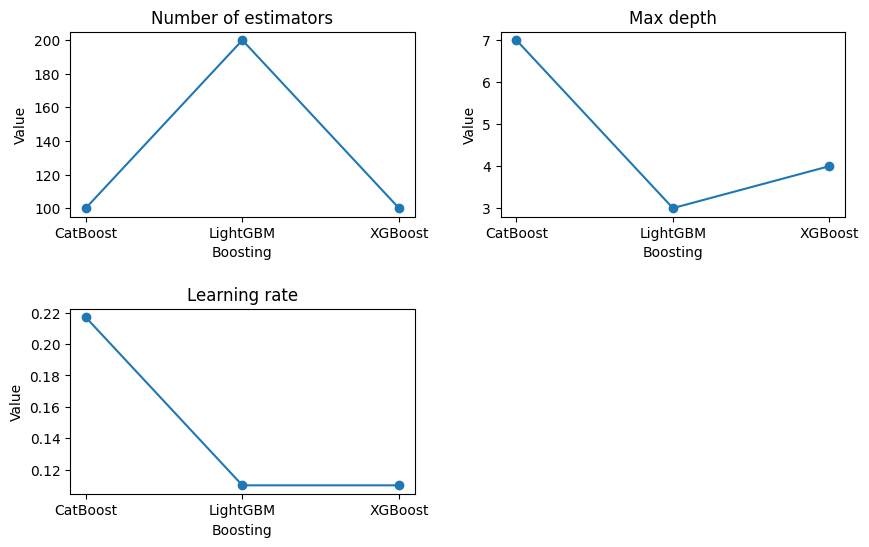

In [288]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

categories = ['Number of estimators', 'Max depth', 'Learning rate']
boosting_types = ['CatBoost', 'LightGBM', 'XGBoost']
iter = [100, 200, 100]
depth = [7, 3, 4]
lr = [0.217, 0.11, 0.11]
total = [iter, depth, lr]

plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace = 0.25, hspace = 0.5)
for i in range(3):
  plt.subplot(gs[i // 2, i % 2])
  plt.plot(boosting_types, total[i], marker='o')
  plt.title(f'{categories[i]}')
  plt.xlabel(f'Boosting')
  plt.ylabel('Value')
plt.show()

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [ ]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [ ]:
# -- YOUR CODE HERE --

Выкиньте строку под названием `user`.

In [ ]:
# -- YOUR CODE HERE --

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [ ]:
# -- YOUR CODE HERE --
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
ben harper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [ ]:
from sklearn.cluster import KMeans

# -- YOUR CODE HERE --

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [ ]:
# -- YOUR CODE HERE --

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [ ]:
from sklearn.preprocessing import normalize

# -- YOUR CODE HERE --

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [ ]:
# -- YOUR CODE HERE --

**Ответ** # -- YOUR ANSWER HERE --

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [ ]:
from scipy.spatial.distance import cosine


centroids = km.cluster_centers_

# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

In [ ]:
import matplotlib.pyplot as plt

# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

In [ ]:
from sklearn.manifold import TSNE

# -- YOUR CODE HERE --

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [ ]:
from sklearn.metrics import silhouette_score

# -- YOUR CODE HERE --

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

Сделайте t-SNE визуализацию полученной кластеризации.

In [ ]:
# -- YOUR CODE HERE --

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --